In [1]:
import fastai
from fastai.vision.all import *
import os
import scipy.io
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from skimage.io import *
import cv2
import glob
import numpy as np

## Loading and Exploration

In [2]:
# Create the ImageCollection object
skimage_collection = ImageCollection('/Users/maxwellkreitman/Desktop/CV_flower_project/pics/*.jpg', load_func=imread, conserve_memory=False, plugin='matplotlib')

# Print the number of images loaded
print(f"Number of images loaded: {len(skimage_collection)}")

Number of images loaded: 8189


In [3]:
#loading imagelabels.mat MATLAB file
mat_labels = loadmat('imagelabels.mat')

In [4]:
#observing what's inside the labels object
labels = mat_labels['labels']
print(labels)

[[77 77 77 ... 62 62 62]]


In [5]:
#turning array into flat list of labels
label_list = labels.flatten().tolist()

In [6]:
#confirming an equal number of labels to picture files of 8,189
print(f"Number of labels loaded: {len(label_list)}")

Number of labels loaded: 8189


In [7]:
#confirming the list has 102 classes as described in the readme
print(f"Number of classes in data: {len(set(label_list))}")

Number of classes in data: 102


In [8]:
#counting occurance of every class between 1 and 102
pic_counts = Counter(label_list)

In [9]:
print(pic_counts)

Counter({51: 258, 77: 251, 46: 196, 73: 194, 89: 184, 74: 171, 81: 166, 94: 162, 88: 154, 78: 137, 83: 131, 43: 130, 95: 128, 41: 127, 75: 120, 58: 114, 82: 112, 56: 109, 60: 109, 37: 108, 76: 107, 80: 105, 65: 102, 72: 96, 44: 93, 53: 93, 50: 92, 23: 91, 96: 91, 11: 87, 12: 87, 84: 86, 8: 85, 30: 85, 17: 85, 52: 85, 18: 82, 90: 82, 98: 82, 29: 78, 71: 78, 91: 76, 36: 75, 48: 71, 55: 71, 40: 67, 47: 67, 59: 67, 57: 67, 92: 66, 28: 66, 97: 66, 5: 65, 85: 63, 87: 63, 99: 63, 70: 62, 54: 61, 66: 61, 2: 60, 22: 59, 42: 59, 86: 58, 101: 58, 20: 56, 4: 56, 38: 56, 62: 55, 63: 54, 68: 54, 69: 54, 64: 52, 31: 52, 61: 50, 13: 49, 19: 49, 49: 49, 15: 49, 100: 49, 14: 48, 102: 48, 93: 46, 9: 46, 33: 46, 32: 45, 10: 45, 6: 45, 35: 43, 24: 42, 67: 42, 26: 41, 25: 41, 16: 41, 79: 41, 39: 41, 3: 40, 1: 40, 21: 40, 27: 40, 34: 40, 45: 40, 7: 40})


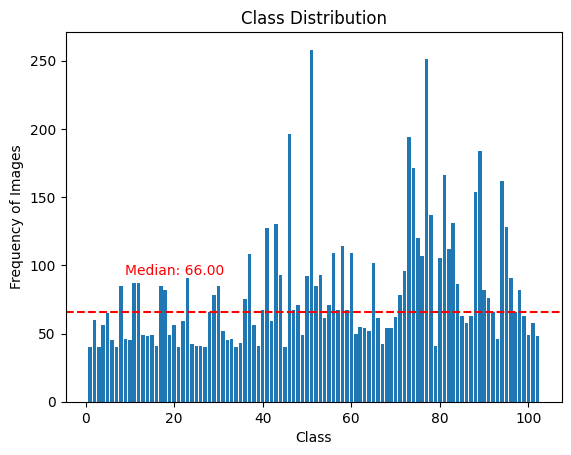

In [10]:
median_value = np.median(list(pic_counts.values()))
#visualizing the distribution over all classes
plt.bar(pic_counts.keys(), pic_counts.values())
plt.xlabel('Class')
plt.ylabel('Frequency of Images')
plt.title('Class Distribution')
plt.axhline(y=median_value, color='red', linestyle='--', label='Average Frequency')
plt.text(20, median_value + 25, f'Median: {median_value:.2f}', color='red', ha='center', va='bottom')
plt.show()

#### Class imbalance seems to be an issue here.  I plan to use weighted loss during dataloader step.

In [11]:
# Calculating class weights
total_samples = sum(pic_counts.values())
class_weights = [total_samples / (len(pic_counts) * pic_counts[class_i]) for class_i in pic_counts.keys()]

total_weight = sum(class_weights)
#normalizing class weights
class_weights_normalized = [weight / total_weight for weight in class_weights]

In [12]:
#minimum frequency of images over all class labels
print(f"Minimum value in the dictionary of labels: {min(pic_counts.values())}")
print(f"Maximum value in the dictionary of labels: {max(pic_counts.values())}")

Minimum value in the dictionary of labels: 40
Maximum value in the dictionary of labels: 258


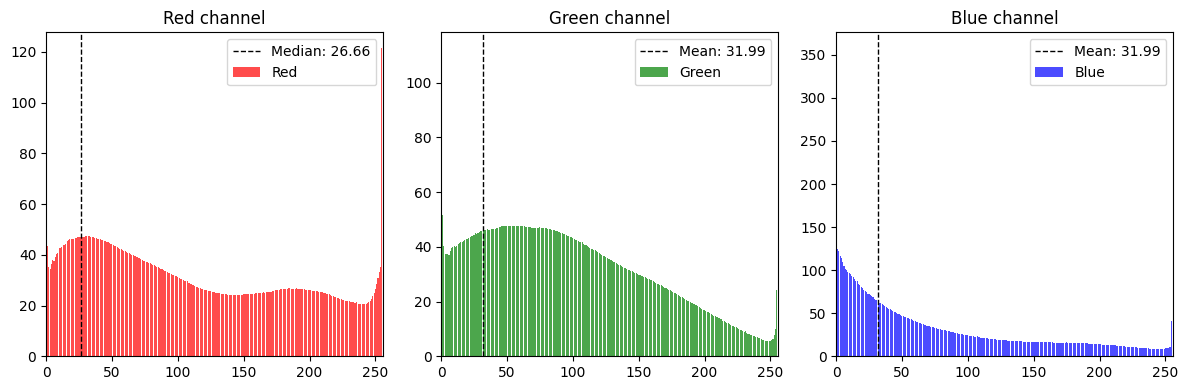

In [13]:
# Initializing arrays to hold all pixel histograms of each channel
hist_r = np.zeros(256)
hist_g = np.zeros(256)
hist_b = np.zeros(256)

# Iterate through each image in the collection
for img in skimage_collection:

    # Split the image into its respective channels
    r, g, b = cv2.split(img)
    
    # Compute histogram for each channel and accumulate
    hist_r += np.histogram(r, bins=256, range=[0,256], density=True)[0]
    hist_g += np.histogram(g, bins=256, range=[0,256], density=True)[0]
    hist_b += np.histogram(b, bins=256, range=[0,256], density=True)[0]

#Median & mean calculations
median_r = np.median(hist_r)
mean_g = np.mean(hist_g)
mean_b = np.mean(hist_b)
    
# Prepare bins for histogram
bins = np.arange(256)

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot histogram for Red channel
axs[0].bar(bins, hist_r, color='red', alpha=0.7, label='Red')
axs[0].set_title('Red channel')
axs[0].set_xlim([0,256])
axs[0].axvline(median_r, color='k', linestyle='dashed', linewidth=1, label=f'Median: {median_r:.2f}')
axs[0].legend()

# Plot histogram for Green channel
axs[1].bar(bins, hist_g, color='green', alpha=0.7, label='Green')
axs[1].set_title('Green channel')
axs[1].set_xlim([0,256])
axs[1].axvline(mean_g, color='k', linestyle='dashed', linewidth=1, label=f'Mean: {mean_g:.2f}')
axs[1].legend()

# Plot histogram for Blue channel
axs[2].bar(bins, hist_b, color='blue', alpha=0.7, label='Blue')
axs[2].set_title('Blue channel')
axs[2].set_xlim([0,256])
axs[2].axvline(mean_b, color='k', linestyle='dashed', linewidth=1, label=f'Mean: {mean_b:.2f}')
axs[2].legend()

# Add legend
for ax in axs:
    ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

### The spike at 255 in the Red channel indicates some outlier data and I decided the median would be a better center to the distribution, while mean suited the Green channel and Blue channel centers of distribution.

### Both red and green channel have right-skew shape.

### Spot checking 4 images belonging to the first 4 classes

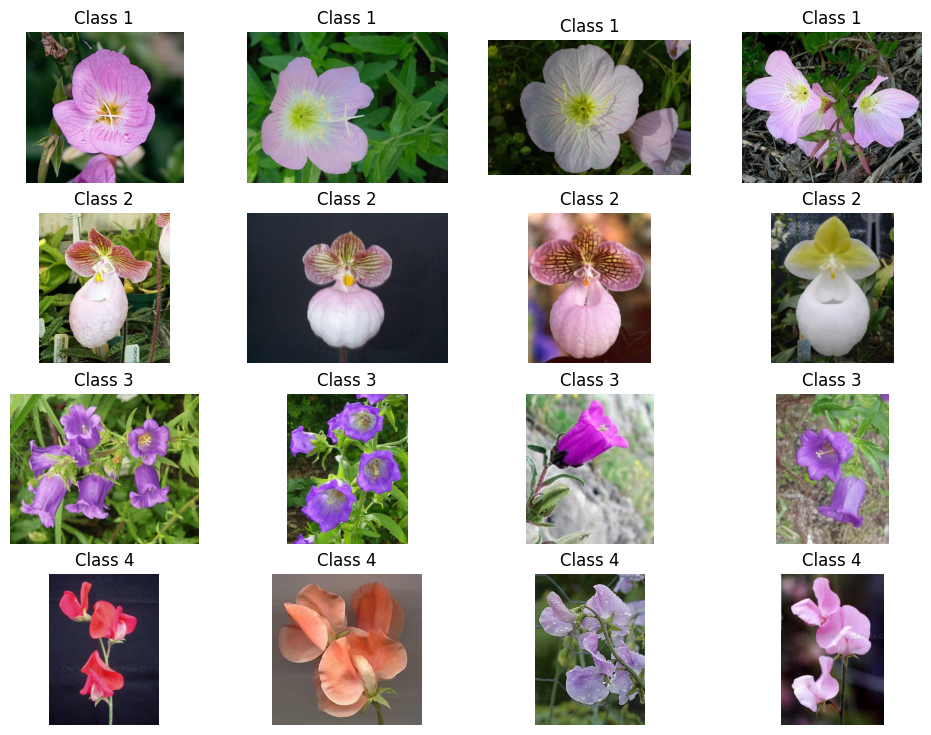

In [14]:
#determining image index group belonging to each class
label_1_indices = np.where(np.array(label_list) == 1)[0][:4]
label_2_indices = np.where(np.array(label_list) == 2)[0][:4]
label_3_indices = np.where(np.array(label_list) == 3)[0][:4]
label_4_indices = np.where(np.array(label_list) == 4)[0][:4]

#plotting images
fig, axes = plt.subplots(4, 4, figsize=(12, 9))

for i, indices in enumerate([label_1_indices, label_2_indices, label_3_indices, label_4_indices]):
    for j, index in enumerate(indices):
        image = skimage_collection[index]
        axes[i, j].imshow(image)
        axes[i, j].set_title(f'Class {label_list[index]}')
        axes[i, j].axis('off')

plt.show()

### Shape and pattern of the flower can vary between pictures of the same class.  There are many instances of complex backgrounds and color variations as well.

### Now I want to visualize the distribution of image dimensions in my data.

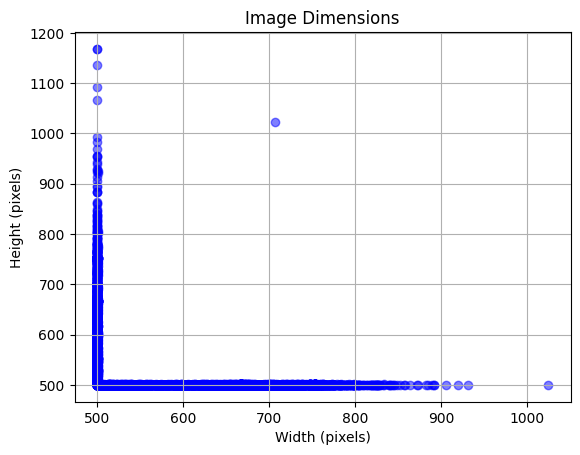

In [15]:
#creating a list of tuples that hold the shape (width and height) of each image
image_dimensions = [(image.shape[1], image.shape[0]) for image in skimage_collection]
#unzipping image_dimensions 
widths, heights = zip(*image_dimensions)
#building a scatter plot
plt.scatter(widths, heights, marker='o', color='blue', alpha=0.5)
plt.title('Image Dimensions')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.grid(True)
plt.show()

### While there are a few outliers, the rest seem to be reasonably similar in size.

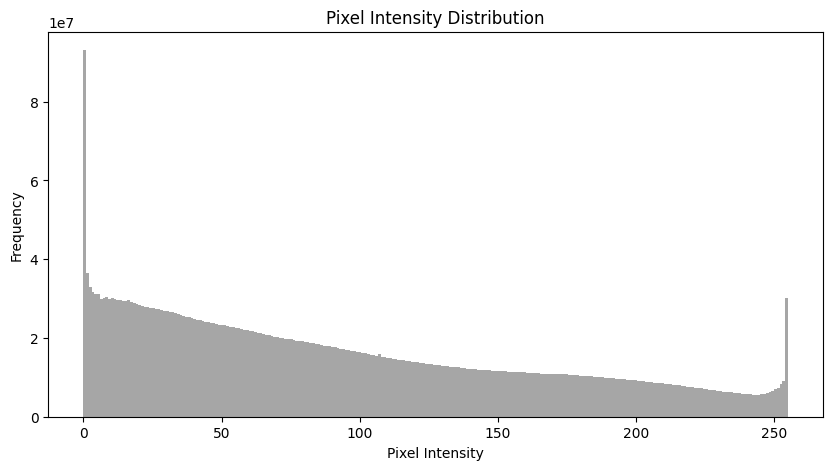

In [16]:
#exploring pixel intensity on the first half the images

# Specify the path to the directory containing your images
images_directory = "/Users/maxwellkreitman/Desktop/CV_flower_project/pics/"
all_image_paths = glob.glob(images_directory + "*.jpg")  

split_index = len(skimage_collection) // 2

# Subset the first half of the images
subset_paths = all_image_paths[:split_index]
skimage_subset = ImageCollection(subset_paths)

pixel_values = [img.flatten() for img in skimage_subset]

plt.figure(figsize=(10, 5))
plt.hist(np.concatenate(pixel_values), bins=256, color='gray', alpha=0.7)
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Pixel Intensity Distribution')
plt.show()

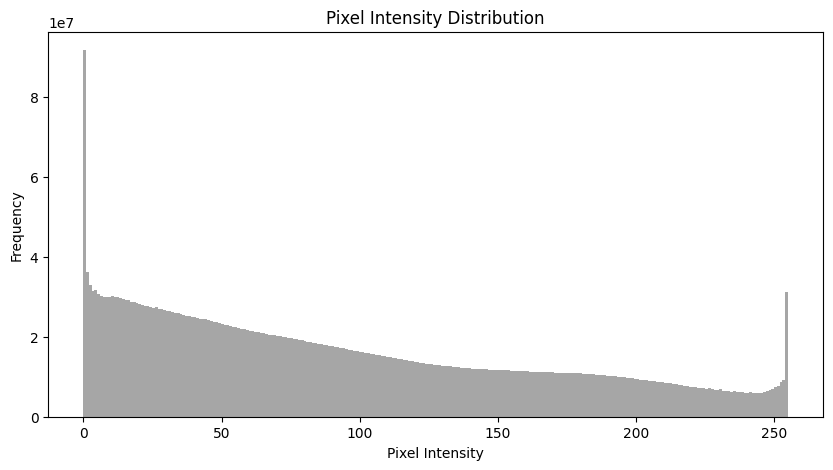

In [17]:
#exploring pixel intensity on second half the images

# Specify the path to the directory containing your images
images_directory = "/Users/maxwellkreitman/Desktop/CV_flower_project/pics/"
all_image_paths = glob.glob(images_directory + "*.jpg")  

split_index = len(skimage_collection) // 2

# Subset the first half of the images
subset_paths = all_image_paths[split_index:]
skimage_subset = ImageCollection(subset_paths)

pixel_values = [img.flatten() for img in skimage_subset]

plt.figure(figsize=(10, 5))
plt.hist(np.concatenate(pixel_values), bins=256, color='gray', alpha=0.7)
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Pixel Intensity Distribution')
plt.show()

### Both graphs show a negative linear relationship and no aparent peak. There are outlier spikes at left and righthand sides.

In [18]:
#loading image files into folder called images
images = get_image_files("/Users/maxwellkreitman/Desktop/CV_flower_project/pics")
#creating dataloader and attaching labels, resizing to 224 pixels, 
#normalizing using precomputed statistics from ImageNet,
#and using normalized class weights calculated earlier to address class imbalance
dls = ImageDataLoaders.from_lists(
    "/Users/maxwellkreitman/Desktop/CV_flower_project/pics",
    fnames=images,
    labels=label_list,
    valid_pct=0.2,
    item_tfms=Resize(224),
    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)],
    class_weights=class_weights_normalized
)

In [19]:
print(str(len(dls.train.dataset))+" images in the training set.")

6552 images in the training set.


In [20]:
print(str(len(dls.valid.dataset)) + " images in the validation set.")

1637 images in the validation set.


### Some examples of pictures from the image data loader:

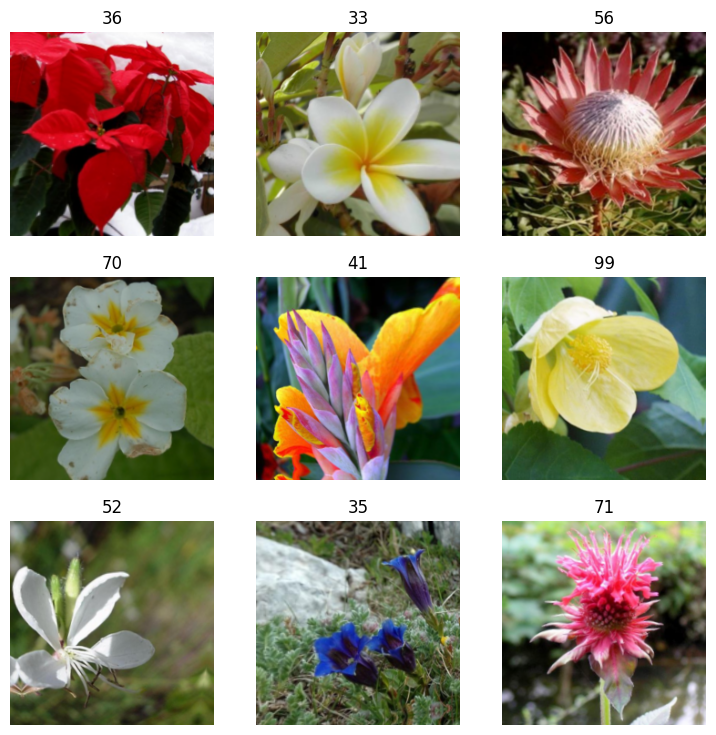

In [21]:
dls.show_batch()

## Modeling

In [22]:
#creating the CV model using pre-trained resnet50
cv_learn = vision_learner(dls, resnet50, metrics=error_rate)

SuggestedLRs(valley=0.0012022644514217973)

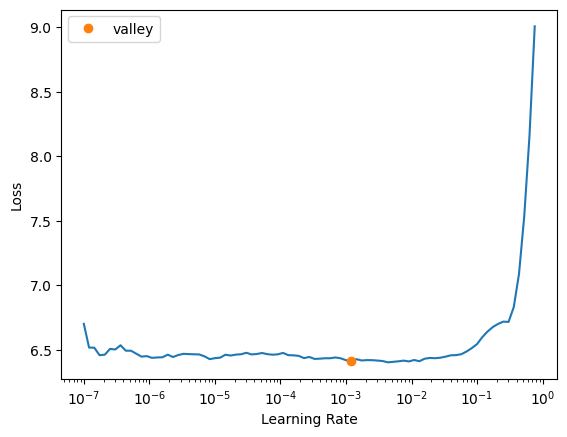

In [23]:
#finding optimal learning rate
cv_learn.lr_find()

In [24]:
#tuning hyperparameters
cv_learn.fine_tune(4, 1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,6.220739,5.265478,0.984117,13:53


epoch,train_loss,valid_loss,error_rate,time
0,5.338148,5.082347,0.981063,18:22
1,5.039797,4.991788,0.968845,16:22
2,4.522081,4.958763,0.975565,8:53:53
3,3.971668,4.946316,0.974954,20:23
